# (Kaggle PetFinder) NLP: fine-tuning a language model 

### Largely adapted from [here](https://gluon-nlp.mxnet.io/examples/sentiment_analysis/sentiment_analysis.html)

## Imports

In [1]:
!pip install --upgrade pip -q
!pip install s3fs -q
!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q
!python -m spacy download en -q
!pip install catboost -q
!pip install opencv-python -q

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Linking successful
/usr/local/lib/python3.6/site-packages/en_core_web_sm -->
/usr/local/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [1]:
%load_ext autoreload
%autoreload 2

from mxnet_utils import *
%matplotlib inline

## Datasets and dataloaders

In [2]:
ctx = mx.gpu(0)

tokenizer = nlp.data.SpacyTokenizer('en')
length_clip = nlp.data.ClipSequence(500)
_, vocab = get_lm(dropout=0.5, ctx=ctx)

In [3]:
data = pd.read_csv('data.csv')
df = data[['petid', 'description', 'adoptionspeed']]

In [4]:
artifacts = load_artifact('artifacts.pkl')
X_train = artifacts['X_train']
X_valid = artifacts['X_valid']

In [5]:
df_train = df.loc[df.petid.isin(X_train.petid)].reset_index(drop=True).reset_index()
df_valid = df.loc[df.petid.isin(X_valid.petid)].reset_index(drop=True).reset_index()

df_train.shape, df_valid.shape, len(df_valid)/(len(df_train)+len(df_valid))

((10045, 4), (4948, 4), 0.33002067631561394)

In [6]:
train_l = df_train[['description', 'adoptionspeed']].values.tolist()
valid_l = df_valid[['description', 'adoptionspeed']].values.tolist()

In [7]:
train_dataloader, valid_dataloader = get_nlp_dls(train_l, valid_l, vocab, length_clip, tokenizer)

(data, length), label = next(iter(train_dataloader))
data.shape, label.shape

((256, 200), (256,))

## Loading the model

In [8]:
net = get_rnn(dropout=0.5, classes=5, ctx=ctx)
net

BaseNet(
  (embedding): HybridSequential(
    (0): Embedding(33278 -> 200, float32)
    (1): Dropout(p = 0.5, axes=())
  )
  (encoder): LSTM(200 -> 200, TNC, num_layers=2, dropout=0.5)
  (agg_layer): MeanPoolingLayer(
  
  )
  (output): HybridSequential(
    (0): Dropout(p = 0.5, axes=())
    (1): Dense(None -> 5, linear)
  )
)

In [9]:
(data, length), label = get_batch(next(iter(train_dataloader)), ctx, app="nlp")

In [10]:
output = forward_pass(net, (data, length), app="nlp")
output.shape

(256, 5)

In [11]:
assert int((output.argmax(axis=1) == mx.nd.SoftmaxActivation(output).argmax(axis=1)).sum().asscalar()) == len(output)

In [12]:
evaluate(net, valid_dataloader, ctx, app="nlp")

(0.1746160064672595, 1.6160404622554778)

## Helper functions: fastai [learning rate finder](https://docs.fast.ai/callbacks.lr_finder.html)

## Training the model

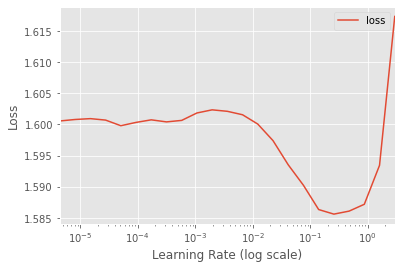

In [13]:
net = get_rnn(dropout=0.3, classes=5, ctx=ctx)
train_dataloader, _ = get_nlp_dls(train_l, valid_l, vocab, length_clip, tokenizer)
_, _, _ = find_lr(net, train_dataloader, ctx, params=net.output.collect_params(), app="nlp")

In [18]:
net = get_rnn(dropout=0.5, classes=5, ctx=ctx)

epochs = 4
lr = 2e-2
_, lr_schedule, mom_schedule = calc_lr_mom_schedule(epochs, len(train_dataloader), lr)
net = fine_tune((train_dataloader, valid_dataloader), 
                  net,
                  lr=lr,
                  ctx=ctx,
                  epochs=epochs,
                  freeze=True,
                  hyper={'lr_schedule': lr_schedule, 'mom_schedule': mom_schedule},
                  app="nlp")

epochs = 10
lr = lr
_, lr_schedule, mom_schedule = calc_lr_mom_schedule(epochs, len(train_dataloader), lr)
net = fine_tune((train_dataloader, valid_dataloader), 
                  net,
                  lr=lr,
                  ctx=ctx,
                  epochs=epochs,
                  freeze=False,
                  hyper={'lr_schedule': lr_schedule, 'mom_schedule': mom_schedule},
                  app="nlp")

[Epoch 0] Train-acc: 0.263, loss: 1.531 | Val-acc: 0.296, loss: 1.468 | time: 0m:3s
[Epoch 1] Train-acc: 0.295, loss: 1.468 | Val-acc: 0.304, loss: 1.455 | time: 0m:3s
[Epoch 2] Train-acc: 0.289, loss: 1.465 | Val-acc: 0.302, loss: 1.454 | time: 0m:3s
[Epoch 3] Train-acc: 0.291, loss: 1.458 | Val-acc: 0.303, loss: 1.454 | time: 0m:3s
[Epoch 0] Train-acc: 0.299, loss: 1.46 | Val-acc: 0.302, loss: 1.452 | time: 0m:3s
[Epoch 1] Train-acc: 0.304, loss: 1.461 | Val-acc: 0.323, loss: 1.442 | time: 0m:3s
[Epoch 2] Train-acc: 0.314, loss: 1.449 | Val-acc: 0.328, loss: 1.435 | time: 0m:3s
[Epoch 3] Train-acc: 0.32, loss: 1.441 | Val-acc: 0.313, loss: 1.437 | time: 0m:3s
[Epoch 4] Train-acc: 0.322, loss: 1.422 | Val-acc: 0.321, loss: 1.434 | time: 0m:3s
[Epoch 5] Train-acc: 0.34, loss: 1.407 | Val-acc: 0.324, loss: 1.432 | time: 0m:3s
[Epoch 6] Train-acc: 0.348, loss: 1.391 | Val-acc: 0.34, loss: 1.431 | time: 0m:3s
[Epoch 7] Train-acc: 0.357, loss: 1.372 | Val-acc: 0.34, loss: 1.42 | time: 0m:3

## Extracting word vectors from the fine-tuned model

In [33]:
net.embedding[0]

Embedding(33278 -> 200, float32)

In [55]:
w2v = net.embedding[0].weight.data()

In [37]:
vocab["am"]

2711

In [71]:
desc = df.description.sample().values[0]
desc

'I found it beside my house, it has been there for 2 days, seemed like the mother abandoned it. I took it home, bathed & fed it. But i cant take care of it due to personal reasons. About the cat: 1. It is white 2. Looks male to me 3. It has BLUE eyes 4. About 2 months old i guess. 5. It is not deaf.'

In [72]:
toks = vocab[tokenizer(desc)]
toks[:5]

[70, 140, 29, 7122, 750]

In [73]:
def embed_desc(desc):
    toks = vocab(tokenizer(desc))
    e = [w2v[w].asnumpy() for w in toks]
    return np.stack(e).mean(axis=0).tolist()+[len(toks)]

In [74]:
embed_desc(desc)[:5]

[0.09255548566579819,
 -0.07124936580657959,
 -0.1555410623550415,
 0.341440886259079,
 -0.1683581918478012]

In [76]:
nl

,description
1345,I rescued Yumi Hamasaki at a food stall far aw...
8371,They are 3 weeks old and they need a home soon.
5730,"Zebra is a sweet-natured, affectionate and ver..."
8882,He is lovely and cute.
3075,Victor is an abandoned dog found in PJ. Rescue...


In [79]:
nl = df[['petid', 'description']].copy().set_index('petid')
nl[[f"vec_{i}" for i in range(200)]+["len_desc"]] = nl.apply(lambda row: embed_desc(row.description), axis='columns', result_type='expand')

In [80]:
nl

,description,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,...,vec_191,vec_192,vec_193,vec_194,vec_195,vec_196,vec_197,vec_198,vec_199,len_desc
petid,,,,,,,,,,,,,,,,,,,,,
86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,0.151120,-0.102192,-0.052737,0.282643,-0.059391,-0.045849,0.092128,0.013442,-0.044945,...,-0.253095,-0.227158,0.126604,0.114728,-0.149004,-0.064265,-0.184537,0.133515,0.156886,77.0
6296e909a,I just found it alone yesterday near my apartm...,0.163723,-0.070171,-0.103796,0.526421,-0.112155,-0.024832,-0.016550,0.106135,-0.174731,...,-0.256325,-0.280767,-0.053725,0.118201,-0.151859,-0.009583,-0.299425,0.103639,0.125480,25.0
3422e4906,Their pregnant mother was dumped by her irresp...,0.017280,-0.024876,-0.101790,0.282415,-0.062788,-0.160843,-0.007236,0.085372,-0.025705,...,-0.136125,-0.142186,0.203002,0.080277,0.048916,-0.004318,-0.194537,0.155570,0.199205,78.0
5842f1ff5,"Good guard dog, very alert, active, obedience ...",0.125524,-0.002457,-0.208021,0.422579,-0.005535,-0.014363,-0.165430,-0.017740,-0.018556,...,-0.030943,-0.028437,0.220444,0.129906,-0.001397,-0.062682,0.148179,0.250583,0.233082,32.0
850a43f90,This handsome yet cute boy is up for adoption....,0.135651,0.006394,-0.136005,0.418407,-0.207315,-0.124794,-0.000064,0.020778,0.004657,...,-0.123884,-0.177743,0.149592,-0.042502,-0.075616,-0.014896,-0.148545,0.147900,0.170952,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dc0935a84,I have 4 kittens that need to be adopt urgentl...,0.047569,-0.142442,-0.156572,0.406026,-0.140067,-0.105401,-0.018070,0.148601,-0.132247,...,-0.166999,-0.219257,0.017398,0.157921,-0.191533,0.047409,-0.226772,0.250913,0.210464,84.0
a01ab5b30,Serato(female cat- 3 color) is 4 years old and...,-0.025889,-0.035227,0.098092,0.436868,-0.183446,-0.091758,0.119769,0.129264,0.061278,...,-0.218676,-0.025364,0.071962,0.043386,-0.008827,-0.134992,-0.204808,0.263911,0.006375,37.0
d981b6395,"Mix breed, good temperament kittens. Love huma...",0.014215,-0.235830,-0.398874,0.284106,-0.129533,-0.457478,-0.061381,0.008042,0.001774,...,-0.004034,0.095107,0.073822,0.434735,-0.155216,0.086012,-0.680121,0.380150,0.119931,13.0


In [81]:
nl.to_csv('nlp.csv')